In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 




import json



In [2]:
import utils_generic as generic
import singletask_dep as st
import model_confs as confs


import train_dep as train

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
torch.manual_seed(27)

In [4]:
model_conf = confs.bert_conf
encoding_type = 'pos'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = st.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_bert_about_pos'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.49489795918367346
MALE 0.9921875
FEMALE 0.0175 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.5202020202020202
MALE 0.9854014598540146
FEMALE 0.01837270341207349 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.5176010430247718
MALE 0.9823232323232324
FEMALE 0.0215633423180593 



  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6814840634317764 	 Validation loss: 0.6785167920387397 	 
  1%|          | 574/57400 [01:27<2:14:16,  7.05it/s]
Epoch 2 	 Training loss: 0.6718538430509667 	 Validation loss: 0.665443111274202 	 
  2%|▏         | 1148/57400 [02:51<2:12:19,  7.09it/s]
Epoch 3 	 Training loss: 0.6502987782921941 	 Validation loss: 0.6264585418216253 	 
  3%|▎         | 1722/57400 [04:16<2:08:17,  7.23it/s]
Epoch 4 	 Training loss: 0.5844076270114255 	 Validation loss: 0.5283687437995005 	 
  4%|▍         | 2296/57400 [05:42<2:15:36,  6.77it/s]
Epoch 5 	 Training loss: 0.489255964392569 	 Validation loss: 0.4455430255097858 	 
  5%|▌         | 2870/57400 [07:07<2:07:13,  7.14it/s]
Epoch 6 	 Training loss: 0.432343442836705 	 Validation loss: 0.40369123826592657 	 
  6%|▌         | 3444/57400 [08:33<2:07:03,  7.08it/s]
Epoch 7 	 Training loss: 0.4019493297105882 	 Validation loss: 0.37914933289511726 	 
  7%|▋         | 4018/57400 [09:58<2:09:33,  6.87it/s]
Epoch 8 	 Training los

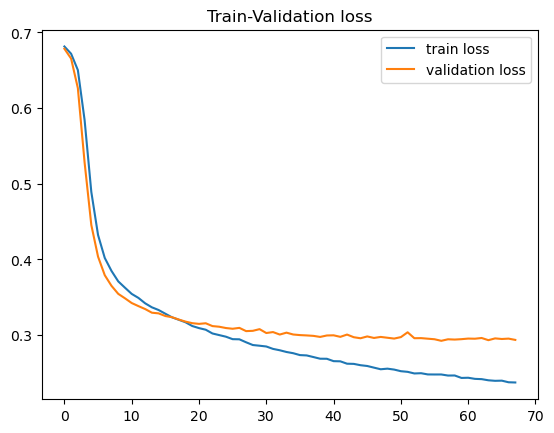

In [17]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path)

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.8545918367346939
MALE 0.8671875
FEMALE 0.8425 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.6843434343434344
MALE 0.708029197080292
FEMALE 0.6587926509186351 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6805736636245111
MALE 0.7045454545454546
FEMALE 0.6549865229110512 



# TO

In [15]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_bert_to_pos'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6957441842514464 	 Validation loss: 0.6942237716610149 	 
  1%|          | 574/57400 [01:25<2:17:55,  6.87it/s]
Epoch 2 	 Training loss: 0.6947356608894228 	 Validation loss: 0.6939229884390103 	 
  2%|▏         | 1148/57400 [02:52<2:10:50,  7.17it/s]
Epoch 3 	 Training loss: 0.6946462878782159 	 Validation loss: 0.6926888550742197 	 
  3%|▎         | 1722/57400 [04:18<2:06:01,  7.36it/s]
Epoch 4 	 Training loss: 0.6942889211692876 	 Validation loss: 0.6931716466354112 	 
  4%|▍         | 2296/57400 [05:45<1:51:27,  8.24it/s]
Epoch 5 	 Training loss: 0.6943104954546753 	 Validation loss: 0.6933562280768055 	 
  5%|▌         | 2870/57400 [07:12<2:03:14,  7.37it/s]
Epoch 6 	 Training loss: 0.6938981447070318 	 Validation loss: 0.693276546769223 	 
  6%|▌         | 3444/57400 [08:39<2:02:04,  7.37it/s]
Epoch 7 	 Training loss: 0.6941488004104601 	 Validation loss: 0.6924820865614939 	 
  7%|▋         | 4018/57400 [10:06<2:06:38,  7.03it/s]
Epoch 8 	 Training los

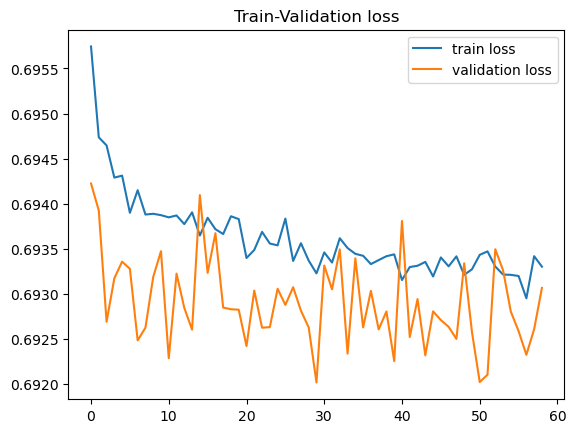

In [16]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path)

In [17]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.5369897959183674
MALE 0.1640625
FEMALE 0.895 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.5025252525252525
MALE 0.13381995133819952
FEMALE 0.9002624671916011 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.5136897001303781
MALE 0.14898989898989898
FEMALE 0.9029649595687331 



# AS

In [18]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
save_path='m1_dep_bert_as_pos'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6945153027253699 	 Validation loss: 0.6933044366917368 	 
  1%|          | 574/57400 [01:27<2:16:41,  6.93it/s]
Epoch 2 	 Training loss: 0.6946542920343551 	 Validation loss: 0.6944583846350848 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [02:53<2:23:15,  6.54it/s]
Epoch 3 	 Training loss: 0.6944301258188507 	 Validation loss: 0.6935979340036037 	 
  3%|▎         | 1722/57400 [04:21<2:16:58,  6.77it/s]
Epoch 4 	 Training loss: 0.693705680686007 	 Validation loss: 0.6929515206207664 	 
  4%|▍         | 2296/57400 [05:48<2:02:27,  7.50it/s]
Epoch 5 	 Training loss: 0.6936304033425627 	 Validation loss: 0.6923148702766936 	 
  5%|▌         | 2870/57400 [07:16<1:59:40,  7.59it/s]
Epoch 6 	 Training loss: 0.6937496668370343 	 Validation loss: 0.693273533198793 	 
  6%|▌         | 3444/57400 [08:43<1:59:19,  7.54it/s]
Epoch 7 	 Training loss: 0.693642351477819 	 Validation loss: 0.6927063929832588 	 
  7%|▋         | 4018/57400 [10:10<2:15:55,  6.55i

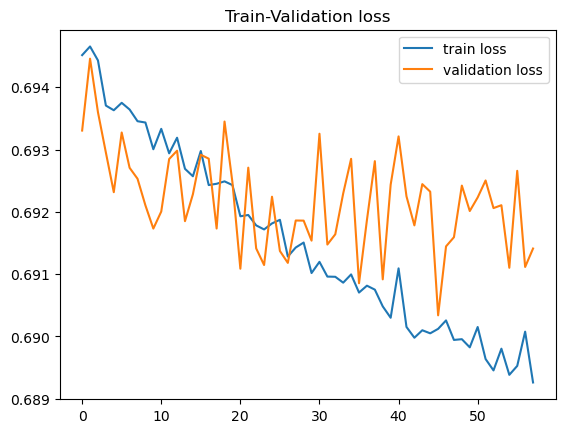

In [19]:
learning_rate = 5e-5
optimizer = SGD(model.parameters(), lr=learning_rate, momentum=0.9)
num_epochs = 100

train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path)

In [20]:
model = st.SingleTaskDep(model_conf,vocab).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print(f"Using scikit learn accuracy por género en el conjunto {task}")
    print(f"GLOBAL: {train.eval_function_single_sk(model,dl_eval[task])}")
    print(f"MALE {train.eval_function_single_sk(model,dl_eval[task],gender='male')}")
    print(f"FEMALE {train.eval_function_single_sk(model,dl_eval[task],gender='female')}",'\n')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using scikit learn accuracy por género en el conjunto about
GLOBAL: 0.6772959183673469
MALE 0.703125
FEMALE 0.6525 

Using scikit learn accuracy por género en el conjunto to
GLOBAL: 0.63510101010101
MALE 0.7104622871046229
FEMALE 0.5538057742782152 

Using scikit learn accuracy por género en el conjunto as
GLOBAL: 0.6401564537157758
MALE 0.6111111111111112
FEMALE 0.6711590296495957 

